In [1]:
import PIL
from scipy import *
import numpy as np
from scipy.interpolate import interp1d
import os
from astropy.io import fits
from matplotlib import cm
from scipy import spatial
import scipy.ndimage as snd
%matplotlib inline

In [2]:
smooth = lambda kmap, sigma: snd.filters.gaussian_filter(kmap.astype(float),sigma,mode='nearest')

In [3]:
states = [PIL.Image.open('spinstates%i.jpg'%(i)) for i in range(1,5)]
states_grey = array([asarray(state.convert('L')) for state in states])
#for i in range(4): print states_grey[i].shape,  std(states_grey[i])

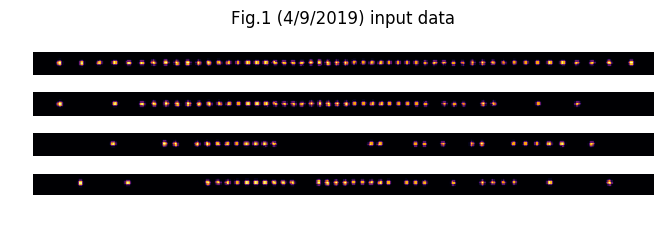

In [4]:
f,axes=subplots(4,1,figsize=(8,2))
for i in range(4):
    axes[i].imshow(states_grey[i],cmap='inferno')
    axes[i].axis('off')
axes[0].set_title('Fig.1 (4/9/2019) input data\n')

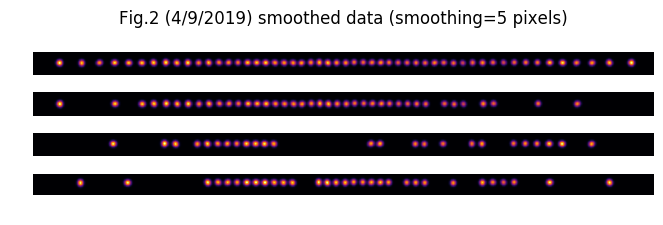

In [5]:
f,axes=subplots(4,1,figsize=(8,2))
for i in range(4):
    axes[i].imshow( smooth(states_grey[i],5),cmap='inferno',interpolation='nearest')
    axes[i].axis('off')
axes[0].set_title('Fig.2 (4/9/2019) smoothed data (smoothing=5 pixels)\n')

In [6]:
def findpeak(img0, smoothing=5):
    img=smooth(img0, smoothing)
    iimg=img[1:-1,1:-1] # remove the edges to prepare for subtraction
    peaks = ((iimg-img[:-2,1:-1]>0) & (iimg-img[2:,1:-1]>0) & 
         (iimg-img[1:-1,:-2]>0) & (iimg-img[1:-1,2:]>0))
    return pad(peaks,1,'constant', constant_values=0)

In [7]:
smoothing_arr=range(20)
peak_arr=array([[sum(findpeak(state, ismoothing)) 
            for state in states_grey] for ismoothing in smoothing_arr])

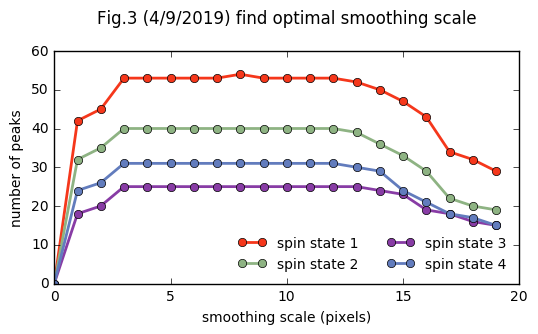

In [8]:
#print peak_arr.shape
i=1
seed(808)
f,ax=subplots(1,1,figsize=(6,3))
for ipeak in peak_arr.T:
    ax.plot(smoothing_arr,ipeak,'o-',label='spin state %i'%(i),color=rand(3),lw=2)
    i+=1
ax.legend(loc=0,fontsize=10,frameon=0,ncol=2)
ax.set_xlabel('smoothing scale (pixels)')
ax.set_ylabel('number of peaks')
ax.set_title('Fig.3 (4/9/2019) find optimal smoothing scale\n') 

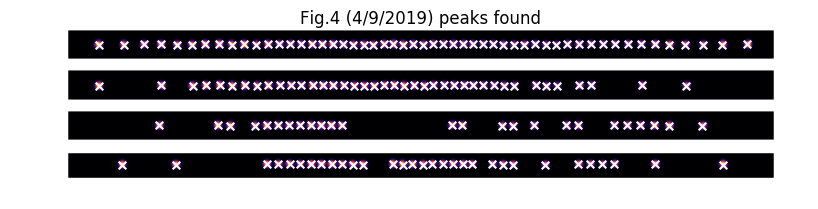

In [9]:
xpeak_arr=[]
f,axes=subplots(4,1,figsize=(10,2))
for i in range(4):
    smoothed=smooth(states_grey[i],5)
    axes[i].imshow(smoothed,cmap='inferno',interpolation='nearest')#,origin='lower')
    y,x=array(where(findpeak(smoothed,0)==1))
    axes[i].scatter(x,y,marker='x',c='w',s=30,lw=1.5)
    axes[i].axis('off')
    xpeak_arr.append(sort(x))
axes[0].set_title('Fig.4 (4/9/2019) peaks found')

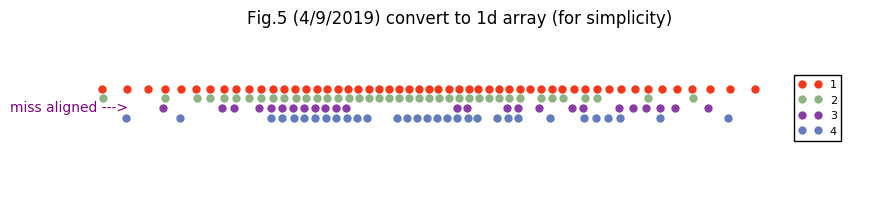

In [10]:
N=xpeak_arr[0][-1]+10
peaks1d_arr = zeros( (4, N))
for i in range(4): peaks1d_arr[i][xpeak_arr[i]]=1
seed(808)
f,ax=subplots(1,1,figsize=(10,2))
for i in range(4):
    icolor=rand(3)
    plot(range(N), peaks1d_arr[i]*(1-i*0.05),'o',markersize=6, 
         color=icolor, markeredgecolor='None',label='%i'%(i+1))
    if i==2:
        ax.text(-200,0.88,'miss aligned --->',color='purple')
ax.set_ylim(0.5, 1.3)
ax.axis('off')
ax.legend(loc='right',fontsize=8)
ax.set_title('Fig.5 (4/9/2019) convert to 1d array (for simplicity)')
show()

In [11]:
def matcharr(base, newarr, extrapad=5):
    idx_base=where(base)[0]
    idx_newarr=where(newarr)[0]
    x0, x1=idx_base[[0,-1]] # the position of the first and last peaks in base
    j0, j1=idx_newarr[[0,-1]] # the position of the first and last peaks in newarr
    dx0, dx1 = sort([x0-j0, x1-j1]) # shift min
    dx0-=extrapad
    dx1+=extrapad
#     print x0, x1, j0, j1, dx0, dx1, len(base)-j1
    if dx0<-j0: dx0=-j0
    if dx1>len(base)-j1: dx1=len(base)-j1
    dx_arr=arange(dx0,dx1+1)    
    match_score=[sum(base[idx_newarr+dx]) for dx in dx_arr]
    dx_best = dx_arr[match_score==amax(match_score)]
    return dx_arr, match_score, dx_best

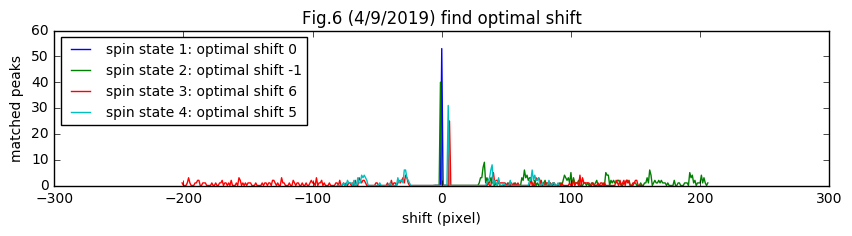

In [12]:
seed(808)
f,ax=subplots(1,1,figsize=(10,2))
for i in range(4):
    dx_arr, match_score, dx_best = matcharr(peaks1d_arr[0], peaks1d_arr[i])
    ax.plot(dx_arr, match_score,label='spin state %i: optimal shift %i'%(i+1, dx_best))
ax.legend(loc='upper left',fontsize=10)
ax.set_title('Fig.6 (4/9/2019) find optimal shift')
ax.set_xlabel('shift (pixel)')
ax.set_ylabel('matched peaks')
show()

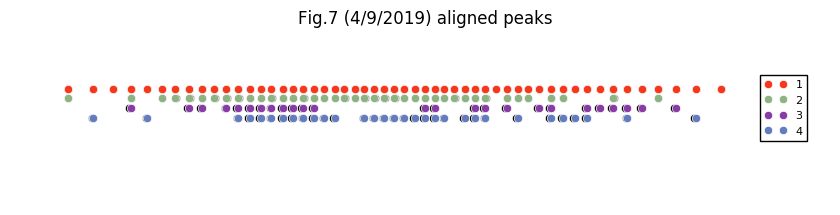

In [13]:
shifts= [matcharr(peaks1d_arr[0], peaks1d_arr[i])[2] for i in range(4)]
peaks1d_arr_shifted = zeros( (4, N))
for i in range(4): peaks1d_arr_shifted[i][xpeak_arr[i]+shifts[i]]=1

seed(808)
f,ax=subplots(1,1,figsize=(10,2))
for i in range(4):
    icolor=rand(3)
    plot(range(N), peaks1d_arr[i]*(1-i*0.05),'o',markersize=6, 
         color='k', markeredgecolor='w')
    plot(range(N), peaks1d_arr_shifted[i]*(1-i*0.05),'o',color=icolor,
         markersize=6,markeredgecolor='w',label='%i'%(i+1))
ax.set_ylim(0.5, 1.3)
ax.axis('off')
ax.legend(loc='right',fontsize=8)
ax.set_title('Fig.7 (4/9/2019) aligned peaks')
show()

In [14]:
xshifted=[where(iarr)[0] for iarr in peaks1d_arr_shifted]
tree=spatial.KDTree(xshifted[0].reshape(-1,1))
matched_pos= [xshifted[0] [tree.query(xshifted[i].reshape(-1,1))[1]] for i in range(4)]
missing_pos=[setxor1d(xshifted[0], matched_pos[i]) for i in range(4)]

peaks1d_arr_missing = zeros((4, N))
for i in range(4): peaks1d_arr_missing[i][missing_pos[i]]=1

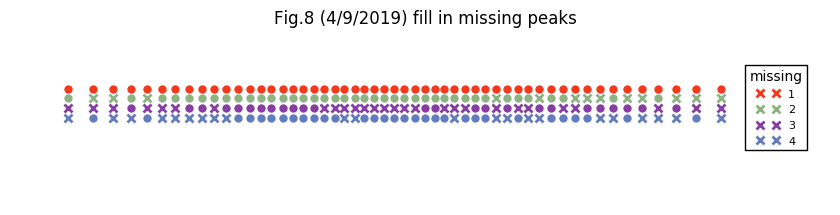

In [15]:
seed(808)
f,ax=subplots(1,1,figsize=(10,2))
for i in range(4):
    icolor=rand(3)
    plot(range(N), peaks1d_arr_shifted[i]*(1-i*0.05),'o',color=icolor,
         markersize=6,markeredgecolor='None')
    plot(range(N), peaks1d_arr_missing[i]*(1-i*0.05),'x',color=icolor,mew=2,label='%i'%(i+1))
ax.set_ylim(0.5, 1.3)
ax.axis('off')
ax.legend(loc='right',fontsize=8,title='missing')
ax.set_title('Fig.8 (4/9/2019) fill in missing peaks')
show()

# next step: noisy data

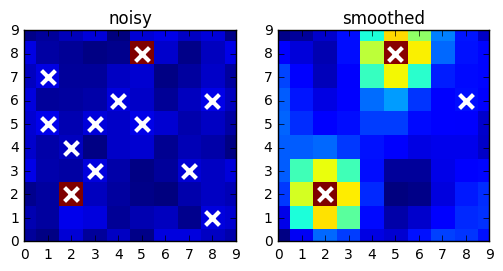

In [16]:
f,(ax1,ax2)=subplots(1,2,figsize=(6,3))
test=rand(10,10)
test[2,2]=10
test[8,5]=10
ax1.imshow(test,interpolation='nearest')#,vmin=0,vmax=1)
iy,ix=array(where(findpeak(test,0)==1))
ax1.scatter(ix,iy,marker='x',c='w',s=100,lw=3)
ax1.set_xlim(0,9);ax1.set_ylim(0,9)
test=smooth(test,1)
ax2.imshow(test,interpolation='nearest')#,vmin=0,vmax=1)
iy,ix=array(where(findpeak(test,0)==1))
ax2.scatter(ix,iy,marker='x',c='w',s=100,lw=3)
ax2.set_xlim(0,9);ax2.set_ylim(0,9)
ax1.set_title('noisy')
ax2.set_title('smoothed')
show()